In [1]:
import numpy as np
import os
import sys

sys.path.append(os.path.abspath('../Scripts'))

In [2]:
import pandas as pd
Tesla_df = pd.read_csv('../Data/TSLA_historical_data.csv')
Vanguard_BND_df = pd.read_csv('../Data/BND_historical_data.csv')
SPY_df = pd.read_csv('../Data/SPY_historical_data.csv')

In [3]:
# Select Adjusted Close prices for each asset
prices = pd.DataFrame({
    'TSLA': Tesla_df['Adj Close'],
    'BND': Vanguard_BND_df['Adj Close'],
    'SPY': SPY_df['Adj Close']
})

# Drop rows with missing values
prices.dropna(inplace=True)

# Split data into train and test sets
train_size = int(len(prices["TSLA"]) * 0.8)
train, test = prices['TSLA'][:train_size], prices['TSLA'][train_size:]

## TSLA

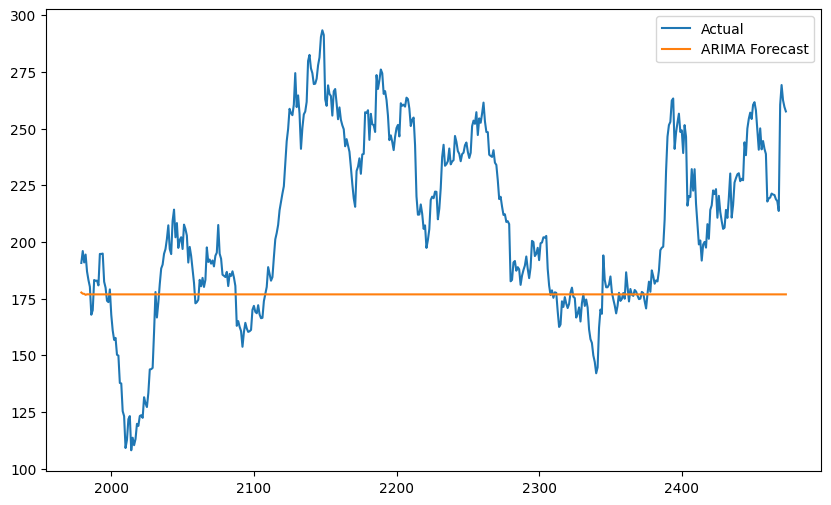

MAE: 39.31
RMSE: 49.57
MAPE: 17.77%


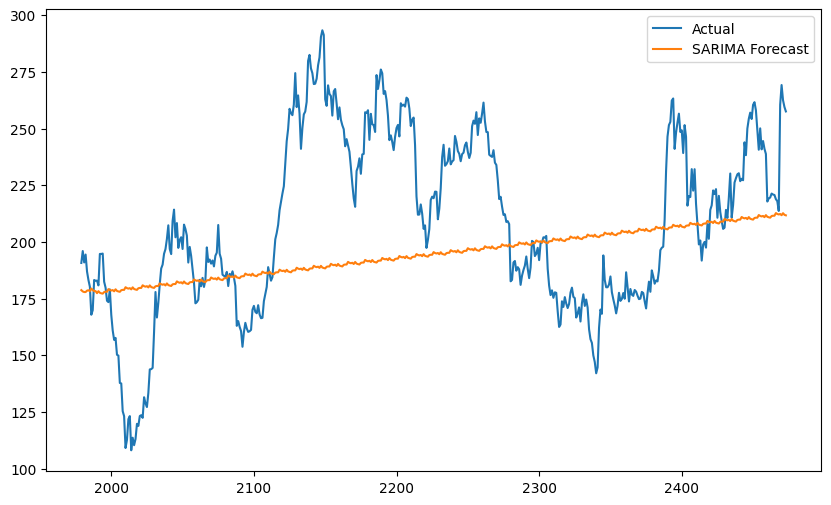

MAE: 31.90
RMSE: 39.55
MAPE: 15.24%
Epoch 1/10
60/60 - 13s - loss: 0.0117 - 13s/epoch - 223ms/step
Epoch 2/10
60/60 - 7s - loss: 0.0012 - 7s/epoch - 111ms/step
Epoch 3/10
60/60 - 6s - loss: 0.0011 - 6s/epoch - 99ms/step
Epoch 4/10
60/60 - 6s - loss: 9.8248e-04 - 6s/epoch - 98ms/step
Epoch 5/10
60/60 - 6s - loss: 8.4771e-04 - 6s/epoch - 101ms/step
Epoch 6/10
60/60 - 6s - loss: 8.3097e-04 - 6s/epoch - 97ms/step
Epoch 7/10
60/60 - 6s - loss: 7.5108e-04 - 6s/epoch - 99ms/step
Epoch 8/10
60/60 - 6s - loss: 7.1600e-04 - 6s/epoch - 98ms/step
Epoch 9/10
60/60 - 5s - loss: 6.2140e-04 - 5s/epoch - 81ms/step
Epoch 10/10
60/60 - 7s - loss: 7.5131e-04 - 7s/epoch - 116ms/step
14/14 [==============================] - 2s 28ms/step


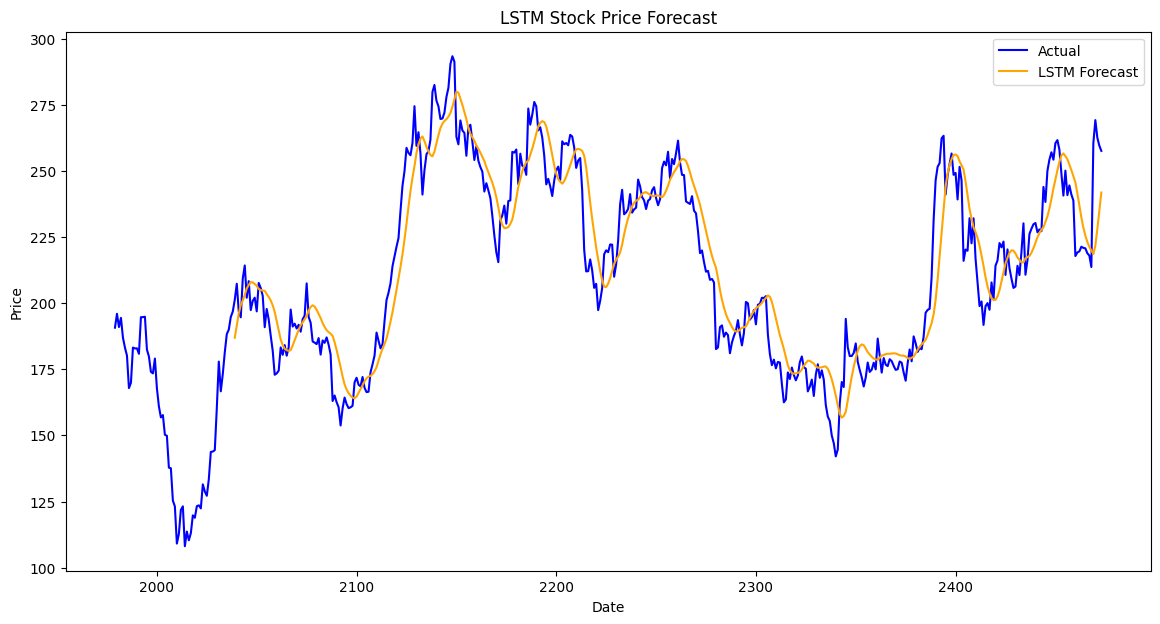

MAE: 10.01
RMSE: 13.07
MAPE: 18.17%


In [4]:
from model import arima,sarima,lstm

arima(train,test)
sarima(train,test)
lstm(train,test)

## Vanguard_BND

In [7]:
# Split data into train and test sets
train_size = int(len(prices["BND"]) * 0.8)
train_BNB, test_BNB = prices['BND'][:train_size], prices['BND'][train_size:]

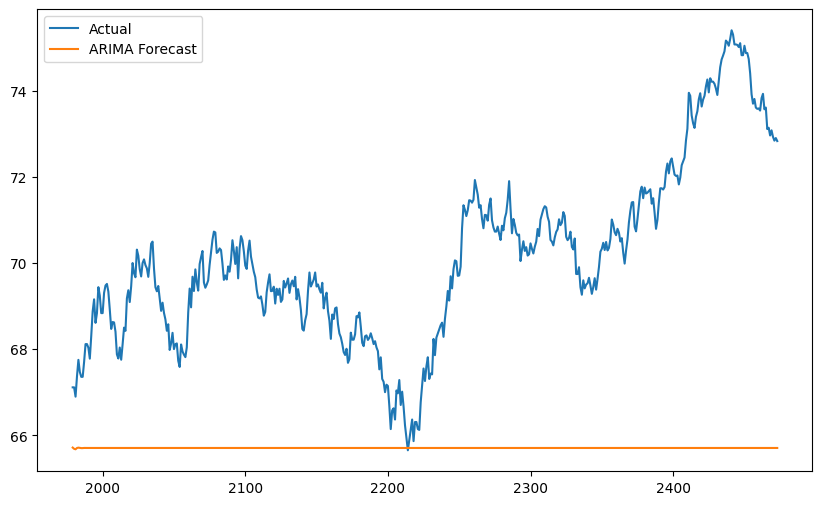

MAE: 4.42
RMSE: 4.88
MAPE: 6.23%


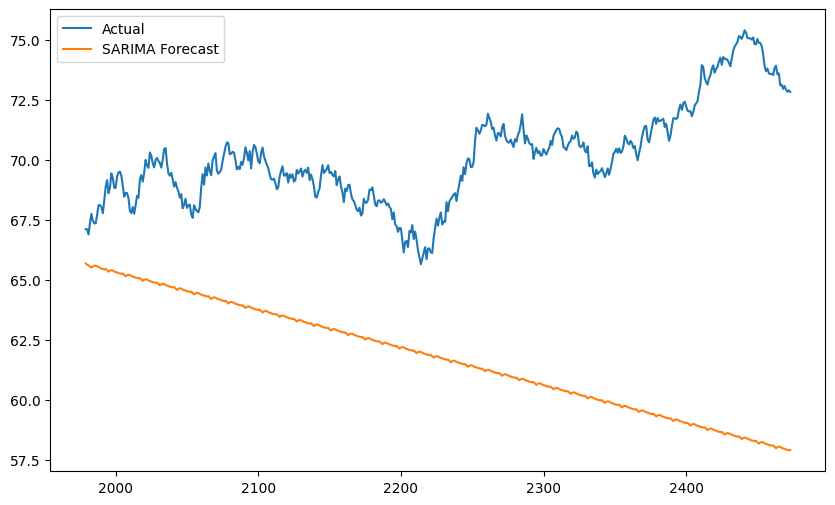

MAE: 8.36
RMSE: 9.25
MAPE: 11.78%
Epoch 1/10
60/60 - 15s - loss: 0.0268 - 15s/epoch - 247ms/step
Epoch 2/10
60/60 - 9s - loss: 8.5663e-04 - 9s/epoch - 144ms/step
Epoch 3/10
60/60 - 5s - loss: 8.2737e-04 - 5s/epoch - 78ms/step
Epoch 4/10
60/60 - 7s - loss: 7.9700e-04 - 7s/epoch - 123ms/step
Epoch 5/10
60/60 - 6s - loss: 7.7298e-04 - 6s/epoch - 97ms/step
Epoch 6/10
60/60 - 6s - loss: 7.8687e-04 - 6s/epoch - 103ms/step
Epoch 7/10
60/60 - 5s - loss: 7.5735e-04 - 5s/epoch - 91ms/step
Epoch 8/10
60/60 - 7s - loss: 7.3028e-04 - 7s/epoch - 112ms/step
Epoch 9/10
60/60 - 7s - loss: 7.2838e-04 - 7s/epoch - 113ms/step
Epoch 10/10
60/60 - 6s - loss: 7.1392e-04 - 6s/epoch - 102ms/step
14/14 [==============================] - 2s 67ms/step


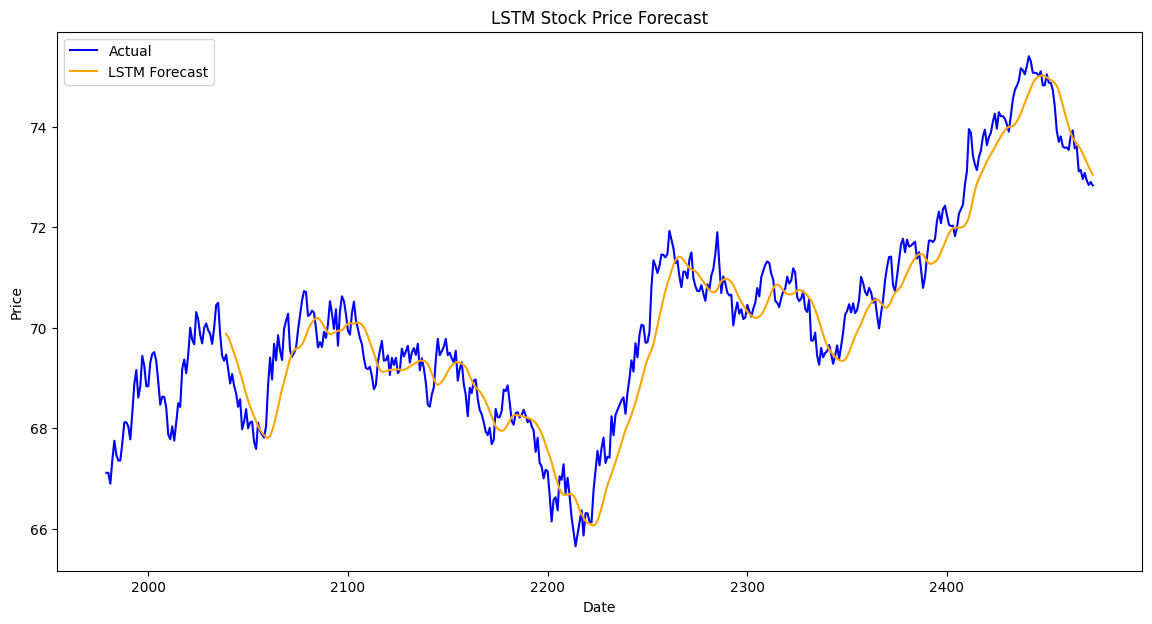

MAE: 0.46
RMSE: 0.56
MAPE: 3.28%


In [8]:
from model import arima,sarima,lstm

arima(train_BNB, test_BNB)
sarima(train_BNB, test_BNB)
lstm(train_BNB, test_BNB)

## SPY

In [9]:
# Split data into train and test sets
train_size = int(len(prices["SPY"]) * 0.8)
train_SPY, test_SPY = prices['SPY'][:train_size], prices['SPY'][train_size:]

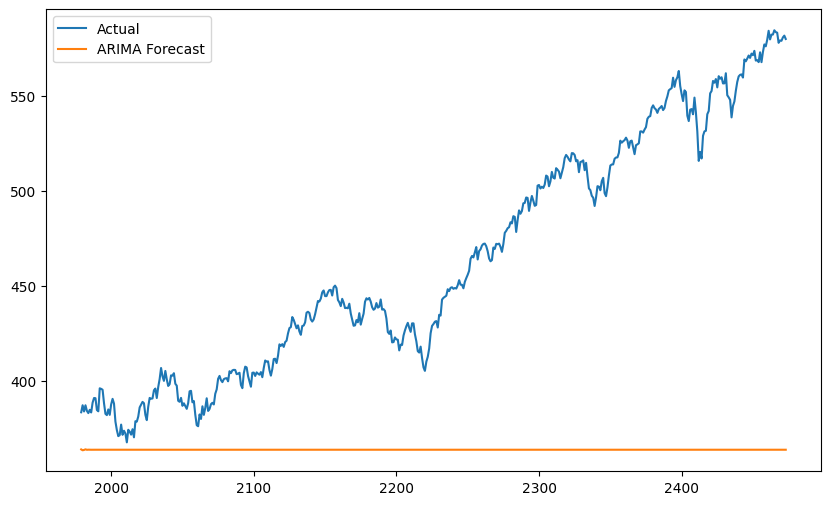

MAE: 99.38
RMSE: 117.42
MAPE: 20.05%


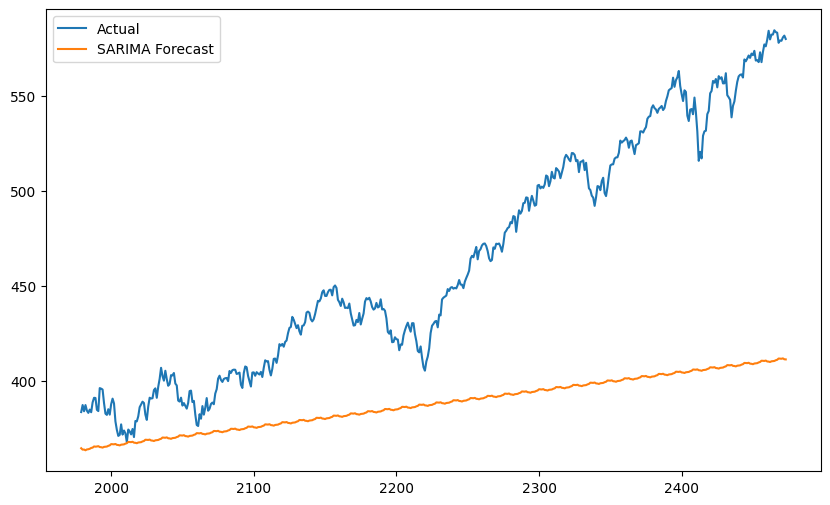

MAE: 75.43
RMSE: 90.11
MAPE: 15.17%
Epoch 1/10
60/60 - 18s - loss: 0.0154 - 18s/epoch - 297ms/step
Epoch 2/10
60/60 - 8s - loss: 6.3847e-04 - 8s/epoch - 134ms/step
Epoch 3/10
60/60 - 4s - loss: 6.3505e-04 - 4s/epoch - 59ms/step
Epoch 4/10
60/60 - 9s - loss: 6.2419e-04 - 9s/epoch - 157ms/step
Epoch 5/10
60/60 - 5s - loss: 6.1164e-04 - 5s/epoch - 75ms/step
Epoch 6/10
60/60 - 10s - loss: 5.8281e-04 - 10s/epoch - 173ms/step
Epoch 7/10
60/60 - 9s - loss: 5.5965e-04 - 9s/epoch - 158ms/step
Epoch 8/10
60/60 - 4s - loss: 5.3286e-04 - 4s/epoch - 72ms/step
Epoch 9/10
60/60 - 9s - loss: 5.2884e-04 - 9s/epoch - 146ms/step
Epoch 10/10
60/60 - 5s - loss: 5.2270e-04 - 5s/epoch - 89ms/step
14/14 [==============================] - 5s 28ms/step


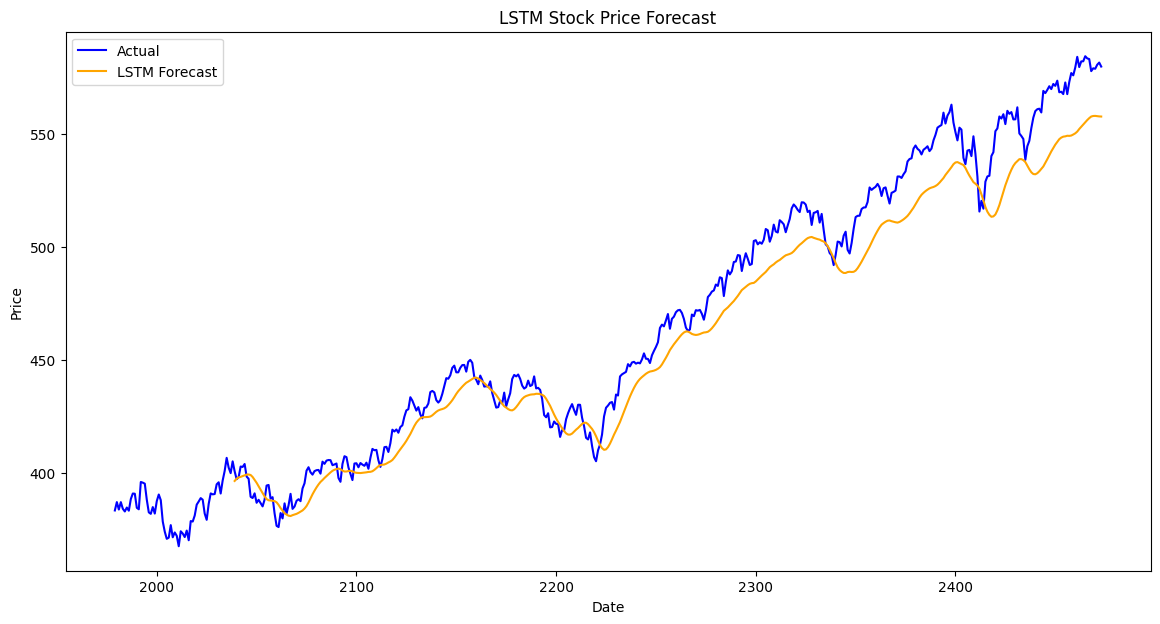

MAE: 12.24
RMSE: 14.77
MAPE: 13.55%


In [10]:
from model import arima,sarima,lstm

arima(train_SPY, test_SPY)
sarima(train_SPY, test_SPY)
lstm(train_SPY, test_SPY)

In [10]:
from pmdarima import auto_arima

#ARIMA parameters
auto_arima_model = auto_arima(train, seasonal=False, trace=True, stepwise=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=6.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=5.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 15.030 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1979
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6168.668
Date:                Mon, 11 Nov 2024   AIC                          12339.337
Time:                        10:28:58   BIC                          12344.927
Sample:                             0   HQIC                         12341.391
   

#### ARIMA Forecasting

Forecast Head:
 1979    177.678130
1980    177.159613
1981    177.093947
1982    176.654713
1983    176.892897
Name: Forecast, dtype: float64
Confidence Interval Head:
       Lower Bound  Upper Bound
1979   166.971856   188.384404
1980   162.300395   192.018830
1981   158.900429   195.287464
1982   155.644205   197.665222
1983   153.213235   200.572559


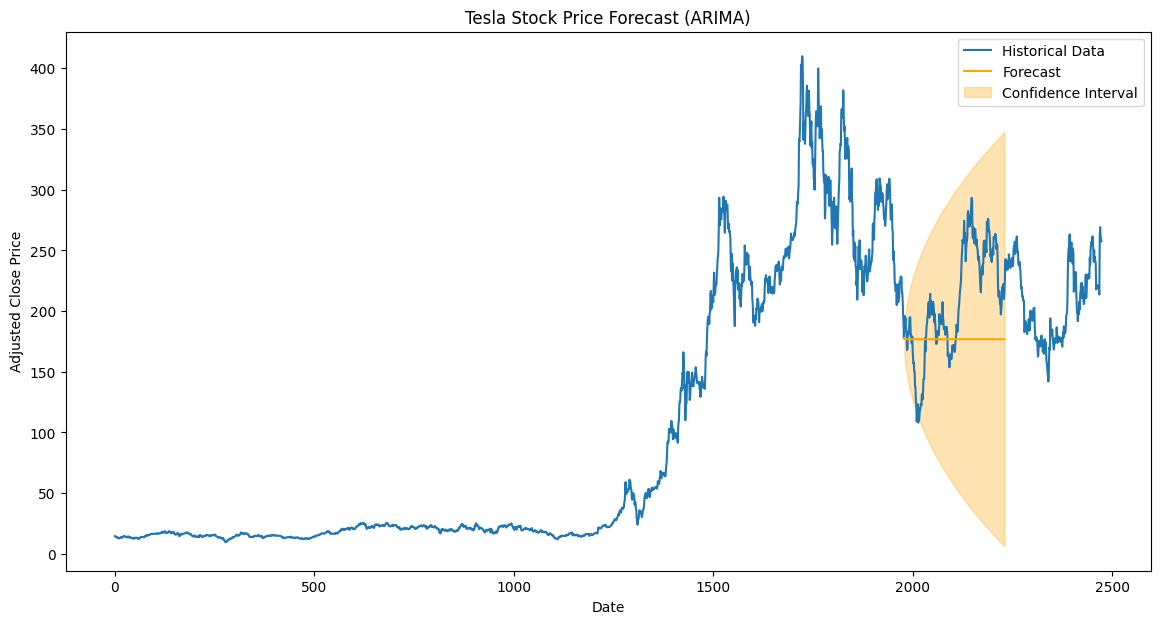

In [13]:
forecast_steps = 252
forecast_result = arima_model.get_forecast(steps=forecast_steps)
forecast = pd.Series(forecast_result.predicted_mean, name="Forecast")

# Retrieve confidence intervals and ensure correct column names
conf_int = forecast_result.conf_int()
conf_int.columns = ["Lower Bound", "Upper Bound"]

# Check the content of forecast and confidence intervals again
print("Forecast Head:\n", forecast.head())
print("Confidence Interval Head:\n", conf_int.head())

# Proceed with plotting if conf_int is now correctly populated
if not forecast.empty and not conf_int.empty and len(forecast) == len(conf_int):
    plt.figure(figsize=(14, 7))
    plt.plot(prices, label="Historical Data")
    plt.plot(forecast.index, forecast, label="Forecast", color="orange")
    plt.fill_between(forecast.index, conf_int["Lower Bound"], conf_int["Upper Bound"], color="orange", alpha=0.3, label="Confidence Interval")
    plt.title("Tesla Stock Price Forecast (ARIMA)")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.show()
else:
    print("Forecast or confidence interval data are still empty or misaligned after processing.")